In [7]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

from IPython.display import display, HTML
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime

In [14]:
def extract(string, key, dtype):
    if dtype is bool:
        return True if re.search(' {}=((True)|(False)) '.format(key), string).group(1) == 'True' else False
    if dtype is float:
        return float(re.search(' {}=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?)'.format(key), string).group(1))
    if dtype is int:
        return float(re.search(' {}=(\d+) '.format(key), string).group(1))

def get_result_metrics(filepath):
    # get lines with results
    lines = []
    marker = 'Got result: '
    with open(filepath) as f:
        for line in f.readlines():
            if marker in line:
                lines.append(line.split(marker, 1)[1])
    
    # extract metrics
    runs = []
    for run in lines:
        if not extract(run, 'success', bool):
            continue
        data = {
            'time_created': extract(run, 'time_created', float),
            'time_input_received': extract(run, 'time_input_received', float),
            'time_compute_started': extract(run, 'time_compute_started', float),
            'time_result_sent': extract(run, 'time_result_sent', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_running': extract(run, 'time_running', float),
            'time_serialize_inputs': extract(run, 'time_serialize_inputs', float),
            'time_deserialize_inputs': extract(run, 'time_deserialize_inputs', float),
            'time_serialize_results': extract(run, 'time_serialize_results', float),
            'time_deserialize_results': extract(run, 'time_deserialize_results', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_async_resolve_proxies': extract(run, 'time_async_resolve_proxies', float),
        }
        

        
        data['client_to_method_server'] = data['time_input_received'] - (
                data['time_created'] + data['time_serialize_inputs'])
        data['worker_to_method_server'] = data['time_result_sent'] - (
                data['time_compute_started'] + data['time_running'] + 
                data['time_deserialize_inputs'] + data['time_serialize_results'] +
                data['time_async_resolve_proxies'])
        data['method_server_to_client'] = data['time_result_received'] - (
                data['time_result_sent'] + data['time_deserialize_results'])
        data['time_serialization'] = sum(data[key] for key in data if 'serialize' in key)
        data['time_created_to_result_received'] = data['time_result_received'] - data['time_created']
        
        runs.append(data)
    
    return pd.DataFrame(runs)

def aggregate_runs(run_paths):
    data = []
    for path in run_paths:
        results = pd.Series({'path': path})

        with open(path) as f:
            first_line = f.readline()
            timestamp = first_line.split(' - ')[0]
            value_server = True if re.search('use_value_server=((True)|(False))', first_line).group(1) == 'True' else False
            results['value_server'] = value_server
            results['reuse_data'] = True if re.search('reuse_data=((True)|(False))', first_line).group(1) == 'True' else False
            results['task_count'] = int(re.search('task_count=(\d+),', first_line).group(1))
            results['task_input_size'] = float(re.search('task_input_size=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['task_interval'] = float(re.search('task_interval=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['task_output_size'] = float(re.search('task_output_size=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['time_start'] = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f").timestamp()

        function_results = get_result_metrics(path)
        results['n_tasks'] = len(function_results.index)
        results['total'] = None
        results = pd.concat([results, function_results.median()])
                
        data.append(results)
        
    return pd.concat(data, axis=1).T

In [15]:
cols = ['client_to_method_server', 'worker_to_method_server', 'method_server_to_client', 'time_serialization', 'time_async_resolve_proxies', 'time_running', 'total']
ind = np.arange(len(cols))
width = 0.35

## Colmena Integration (auto value server usage)

,path,value_server,reuse_data,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/50KBx50_1s/2021-02-23_22-06-40/runtime.log,True,True,50,0.05,1,0,1.61412e+09,50,0.016600,...,0.000297103,0.00015381,0.00042811,5.91825e-05,9.17555e-05,0.000510812,0.0041182,0.00058341,0.000918564,0.0306365
1,runs/50KBx50_1s/2021-02-23_22-09-31/runtime.log,False,True,50,0.05,1,0,1.61412e+09,50,0.019760,...,0.000164516,0.000792476,0.000894191,0.000147651,4.245e-05,0.00119555,0.00472093,0.00149751,0.00202615,4.95374
2,runs/50KBx50_1s/2021-02-23_22-10-42/runtime.log,True,False,50,0.05,1,0,1.61412e+09,50,0.018149,...,0.000793255,0.00015556,0.000431866,4.87315e-05,0.00188216,0.000471592,0.00354922,0.000425935,0.00142162,109.107
3,runs/50KBx50_1s/2021-02-23_22-13-08/runtime.log,False,False,50,0.05,1,0,1.61412e+09,50,0.018867,...,0.000169143,0.000788291,0.000887441,0.000136125,4.1705e-05,0.00116742,0.00404882,0.00134265,0.00199481,117.115


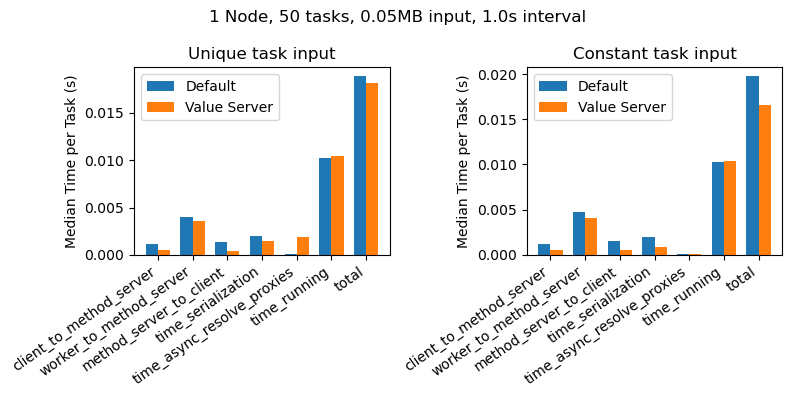

In [38]:
rundir = 'runs/50KBx50_1s'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server_unique = results.loc[results['value_server'] == False].loc[results['reuse_data'] == False][cols]
value_server_unique = results.loc[results['value_server'] == True].loc[results['reuse_data'] == False][cols]

no_value_server_reuse = results.loc[results['value_server'] == False].loc[results['reuse_data'] == True][cols]
value_server_reuse = results.loc[results['value_server'] == True].loc[results['reuse_data'] == True][cols]

width = 0.35
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi= 100)

ax[0].bar(ind, no_value_server_unique.to_numpy()[0], width, label='Default')
ax[0].bar(ind+width, value_server_unique.to_numpy()[0], width, label='Value Server')

ax[1].bar(ind, no_value_server_reuse.to_numpy()[0], width, label='Default')
ax[1].bar(ind+width, value_server_reuse.to_numpy()[0], width, label='Value Server')

fig.suptitle('1 Node, {} tasks, {}MB input, {}s interval'.format(results['n_tasks'].iloc[0], results['task_input_size'].iloc[0], results['task_interval'].iloc[0]))
plt.setp(ax, ylabel='Median Time per Task (s)', xticks=ind + width/2, xticklabels=cols)
plt.setp(ax[0].get_xticklabels(), rotation=35, ha='right')
plt.setp(ax[1].get_xticklabels(), rotation=35, ha='right')
ax[0].set_title('Unique task input')
ax[1].set_title('Constant task input')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
fig.tight_layout()
plt.show()

,path,value_server,reuse_data,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/1MBx50_1s/2021-02-23_20-57-50/runtime.log,False,False,50,1,1,0,1.61411e+09,50,0.091128,...,0.00314427,0.0115938,0.0105147,0.0016002,4.9155e-05,0.0150476,0.0185851,0.0201348,0.0269166,0.137207
1,runs/1MBx50_1s/2021-02-23_20-58-57/runtime.log,True,False,50,1,1,0,1.61411e+09,50,0.039478,...,0.0053509,0.000166587,0.000435169,6.57755e-05,0.0189653,0.000403881,0.00305545,0.000521541,0.00601395,117.104
2,runs/1MBx50_1s/2021-02-23_21-01-47/runtime.log,False,True,50,1,1,0,1.61411e+09,50,0.093994,...,0.00354619,0.0115938,0.0105302,0.00158367,4.81055e-05,0.0178938,0.0184141,0.0199955,0.0273526,103.887
3,runs/1MBx50_1s/2021-02-23_21-04-21/runtime.log,True,True,50,1,1,0,1.61411e+09,50,0.015924,...,0.000267296,0.000153136,0.000429603,4.7754e-05,9.31055e-05,0.000429749,0.00353146,0.000459194,0.000899328,103.768


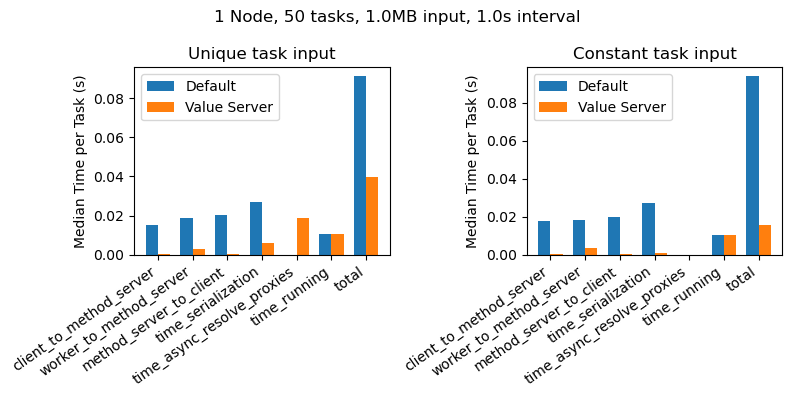

In [37]:
rundir = 'runs/1MBx50_1s'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server_unique = results.loc[results['value_server'] == False].loc[results['reuse_data'] == False][cols]
value_server_unique = results.loc[results['value_server'] == True].loc[results['reuse_data'] == False][cols]

no_value_server_reuse = results.loc[results['value_server'] == False].loc[results['reuse_data'] == True][cols]
value_server_reuse = results.loc[results['value_server'] == True].loc[results['reuse_data'] == True][cols]

width = 0.35
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi= 100)

ax[0].bar(ind, no_value_server_unique.to_numpy()[0], width, label='Default')
ax[0].bar(ind+width, value_server_unique.to_numpy()[0], width, label='Value Server')

ax[1].bar(ind, no_value_server_reuse.to_numpy()[0], width, label='Default')
ax[1].bar(ind+width, value_server_reuse.to_numpy()[0], width, label='Value Server')

fig.suptitle('1 Node, {} tasks, {}MB input, {}s interval'.format(results['n_tasks'].iloc[0], results['task_input_size'].iloc[0], results['task_interval'].iloc[0]))
plt.setp(ax, ylabel='Median Time per Task (s)', xticks=ind + width/2, xticklabels=cols)
plt.setp(ax[0].get_xticklabels(), rotation=35, ha='right')
plt.setp(ax[1].get_xticklabels(), rotation=35, ha='right')
ax[0].set_title('Unique task input')
ax[1].set_title('Constant task input')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
fig.tight_layout()
plt.show()

,path,value_server,reuse_data,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/1MBin1MBoutx50_5s/2021-02-24_16-32-03/run...,False,False,50,1,5,1,1.61418e+09,50,0.147401,...,0.00390247,0.011594,0.0205434,0.00342918,4.9235e-05,0.0179856,0.0391976,0.0397767,0.0400952,0.197589
1,runs/1MBin1MBoutx50_5s/2021-02-24_16-37-21/run...,True,False,50,1,5,1,1.61418e+09,50,0.071723,...,0.00764475,0.000155236,0.0225247,5.22455e-05,0.027739,0.000940204,0.00681949,0.000657201,0.0250467,0.101177


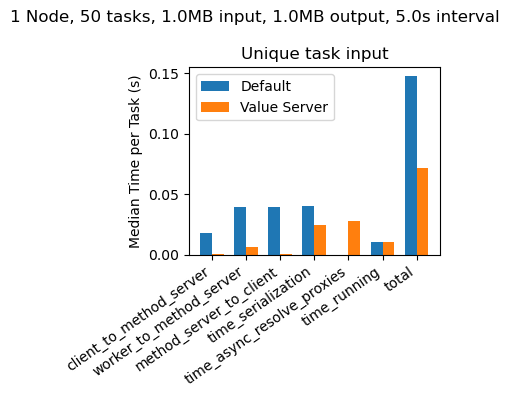

In [45]:
rundir = 'runs/1MBin1MBoutx50_5s'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server_unique = results.loc[results['value_server'] == False].loc[results['reuse_data'] == False][cols]
value_server_unique = results.loc[results['value_server'] == True].loc[results['reuse_data'] == False][cols]

#no_value_server_reuse = results.loc[results['value_server'] == False].loc[results['reuse_data'] == True][cols]
#value_server_reuse = results.loc[results['value_server'] == True].loc[results['reuse_data'] == True][cols]

width = 0.35
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100)

ax.bar(ind, no_value_server_unique.to_numpy()[0], width, label='Default')
ax.bar(ind+width, value_server_unique.to_numpy()[0], width, label='Value Server')

fig.suptitle('1 Node, {} tasks, {}MB input, {}MB output, {}s interval'.format(results['n_tasks'].iloc[0], results['task_input_size'].iloc[0], results['task_output_size'].iloc[0], results['task_interval'].iloc[0]))
plt.setp(ax, ylabel='Median Time per Task (s)', xticks=ind + width/2, xticklabels=cols)
plt.setp(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_title('Unique task input')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

,path,value_server,reuse_data,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/1MBx200_1s_4node/2021-02-24_21-25-04/runt...,True,False,200,1,2,0,1.6142e+09,200,0.048478,...,0.000321386,0.0001592,0.000432952,6.2851e-05,0.0216266,0.000595212,0.0142971,0.000630498,0.00100795,0.0638905
1,runs/1MBx200_1s_4node/2021-02-24_21-33-09/runt...,False,False,200,1,2,0,1.6142e+09,200,0.101306,...,0.0034786,0.0115923,0.0105161,0.00168519,4.84555e-05,0.015666,0.0271312,0.0204898,0.0275675,0.13891
2,runs/1MBx200_1s_4node/2021-02-24_21-40-12/runt...,True,True,200,1,2,0,1.6142e+09,200,0.026415,...,0.000260148,0.000156475,0.000433592,5.47235e-05,9.72205e-05,0.000542283,0.0140716,0.000485897,0.000915652,0.0441769
3,runs/1MBx200_1s_4node/2021-02-24_21-47-05/runt...,False,True,200,1,2,0,1.6142e+09,200,0.105589,...,0.00320544,0.0116002,0.0105543,0.00179372,4.9706e-05,0.0155498,0.0304664,0.0218679,0.0272846,0.145744


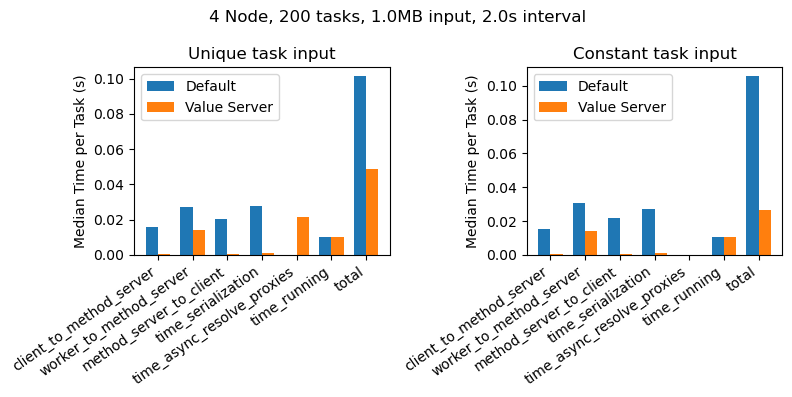

In [47]:
rundir = 'runs/1MBx200_1s_4node'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server_unique = results.loc[results['value_server'] == False].loc[results['reuse_data'] == False][cols]
value_server_unique = results.loc[results['value_server'] == True].loc[results['reuse_data'] == False][cols]

no_value_server_reuse = results.loc[results['value_server'] == False].loc[results['reuse_data'] == True][cols]
value_server_reuse = results.loc[results['value_server'] == True].loc[results['reuse_data'] == True][cols]

width = 0.35
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi= 100)

ax[0].bar(ind, no_value_server_unique.to_numpy()[0], width, label='Default')
ax[0].bar(ind+width, value_server_unique.to_numpy()[0], width, label='Value Server')

ax[1].bar(ind, no_value_server_reuse.to_numpy()[0], width, label='Default')
ax[1].bar(ind+width, value_server_reuse.to_numpy()[0], width, label='Value Server')

fig.suptitle('4 Node, {} tasks, {}MB input, {}s interval'.format(results['n_tasks'].iloc[0], results['task_input_size'].iloc[0], results['task_interval'].iloc[0]))
plt.setp(ax, ylabel='Median Time per Task (s)', xticks=ind + width/2, xticklabels=cols)
plt.setp(ax[0].get_xticklabels(), rotation=35, ha='right')
plt.setp(ax[1].get_xticklabels(), rotation=35, ha='right')
ax[0].set_title('Unique task input')
ax[1].set_title('Constant task input')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
fig.tight_layout()
plt.show()